<a href="https://colab.research.google.com/github/AmrAlaaFCIH/NormalEquationRegression/blob/main/ApartmentPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv"

--2021-09-30 19:54:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.1’

AB_NYC_2019.csv.1   100%[===================>]   6.75M  23.0MB/s    in 0.3s    

2021-09-30 19:54:24 (23.0 MB/s) - ‘AB_NYC_2019.csv.1’ saved [7077973/7077973]



In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [5]:
df=pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [8]:
df.drop(columns=["last_review","reviews_per_month"],inplace=True)
df.dropna(inplace=True)
df.drop_duplicates()
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [9]:
display(df.shape)
df.isna().sum()

(48858, 14)

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

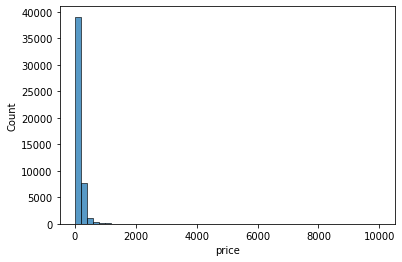

In [10]:
sns.histplot(df["price"],bins=50)

In [11]:
for column in df.columns:
  display(str(column)+":"+str(df[column].nunique())+" "+str(df[column].dtype))

'id:48858 int64'

'name:47884 object'

'host_id:37425 int64'

'host_name:11450 object'

'neighbourhood_group:5 object'

'neighbourhood:221 object'

'latitude:19039 float64'

'longitude:14716 float64'

'room_type:3 object'

'price:674 int64'

'minimum_nights:108 int64'

'number_of_reviews:394 int64'

'calculated_host_listings_count:47 int64'

'availability_365:366 int64'

In [12]:
#take the data for training 
model_data=df[["neighbourhood_group","latitude","longitude","room_type","minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365","price"]]
model_data.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price
0,Brooklyn,40.64749,-73.97237,Private room,1,9,6,365,149
1,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,2,355,225
2,Manhattan,40.80902,-73.94190,Private room,3,0,1,365,150
3,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,1,194,89
4,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,1,0,80


In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
neighbourhood=OneHotEncoder(sparse=False)
room=OneHotEncoder(sparse=False)
neighbourhood.fit(df["neighbourhood_group"].to_numpy().reshape(-1,1))
room.fit(df["room_type"].to_numpy().reshape(-1,1))

def prepare_data(df,neighbourhoodEncoder,roomEncoder):
  df=df.copy()
  arr1=neighbourhoodEncoder.transform(df["neighbourhood_group"].to_numpy().reshape(-1,1))
  arr2=roomEncoder.transform(df["room_type"].to_numpy().reshape(-1,1))
  df1=pd.DataFrame(arr1,columns=["neighbourhood_{}".format(x) for x in range(arr1.shape[1])])
  df1=df1.iloc[:,:-1]
  df2=pd.DataFrame(arr2,columns=["room_{}".format(x) for x in range(arr2.shape[1])])
  df2=df2.iloc[:,:-1]
  df.drop(columns=["neighbourhood_group","room_type"],inplace=True)
  return pd.concat([df1.reset_index(drop=True),df2.reset_index(drop=True),df.reset_index(drop=True)],axis=1)

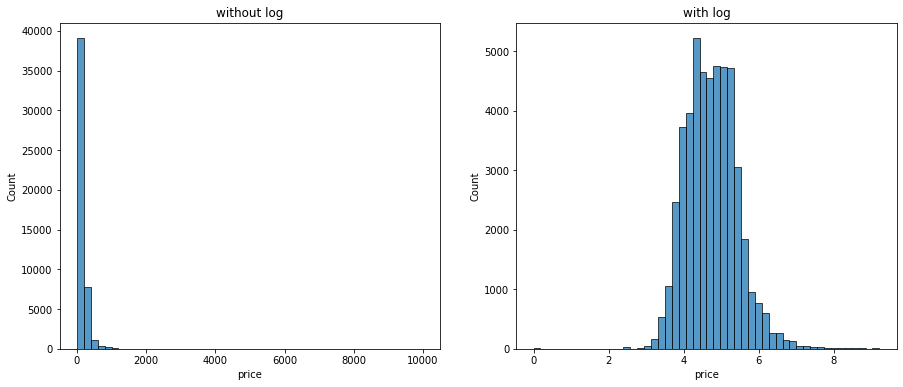

In [15]:
#apply log1p to price to check the diff in dist
fig,ax=plt.subplots(1,2,figsize=(15,6))
sns.histplot(model_data["price"],bins=50,ax=ax[0]).set_title("without log")
sns.histplot(np.log1p(model_data["price"]),bins=50,ax=ax[1]).set_title("with log")
plt.show()

so the log transformation is what we want to use with the model so we will consider it while training 

In [16]:
#let's split data to train,test and validation sets 60 , 20 , 20
model_data_train,model_data_test=train_test_split(model_data,test_size=0.4,random_state=42)
model_data_test,model_data_validate=train_test_split(model_data_test,test_size=0.5,random_state=42)
for data in [model_data_train,model_data_test,model_data_validate]:
  data.reset_index(drop=True,inplace=True)

for data in [model_data_train,model_data_test,model_data_validate]:
  display(data.shape)


(29314, 9)

(9772, 9)

(9772, 9)

In [17]:
x_train=model_data_train.iloc[:,:-1]
y_train=model_data_train.iloc[:,-1]
#now we prepare the data and log transform the target 
x_train=prepare_data(x_train,neighbourhood,room)
y_train=np.log1p(y_train)

In [33]:
#now we will write the write the equation for normal equation and apply a regulariztion parameter to it 
def LinearRegression(x,y,reg=0.001):
  x=np.column_stack([np.ones(x.shape[0]),x])
  matrix=np.eye(x.shape[1])*reg
  return np.linalg.inv(x.T.dot(x)+matrix).dot(x.T).dot(y)

def predict(x,model):
  x=np.column_stack([np.ones(x.shape[0]),x])
  return x.dot(model)

def RMSE(prediction,data):
  return np.sqrt(np.mean((prediction-data)**2))

In [41]:
model=LinearRegression(x_train,y_train,0.0001)

In [40]:
#evalute the model
prediction=predict(x_train,model)
RMSE(prediction,y_train)

0.49773175261720637

In [42]:
#testing the model on test data
x_test=model_data_train.iloc[:,:-1]
y_test=model_data_train.iloc[:,-1]
#now we prepare the data and log transform the target 
x_test=prepare_data(x_test,neighbourhood,room)
y_test=np.log1p(y_test)

In [43]:
prediction2=predict(x_test,model)
RMSE(prediction2,y_test)

0.497735545654345

The model is doing well on test data and there isn't any issue with the fitting 

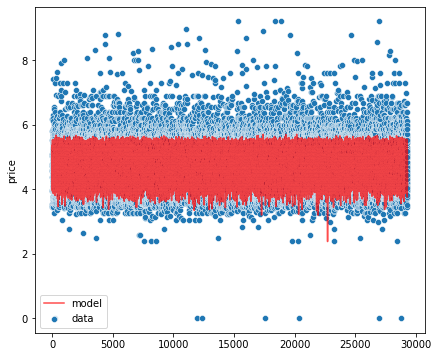

In [59]:
#Graphical represintation of the model 
fig,ax=plt.subplots(figsize=(7,6))
sns.scatterplot(x=x_train.index,y=y_train,ax=ax,label="data")
ax.plot(x_train.index,prediction,color="red",label="model",alpha=0.7)
plt.legend()